In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('/Users/vikkyfury/Desktop/pr/program/LangWiz-AI/artifacts/data/europarl/processed/fr_en/fr_en.csv')
data.head()

,source_text,target_text
0,4.,4.
1,Ratification et mise en œuvre des conventions ...,The ratification and implementation of the upd...
2,7.,7.
3,Agriculture durable et biogaz: nécessité de re...,Sustainable agriculture and biogas: review of ...
4,- Avant le vote sur le paragraphe 41:,- Before the vote on paragraph 41:


In [2]:
import pandas as pd
import numpy as np

def save_csv_percentage(input_file, output_file, percentage):
    df = pd.read_csv(input_file)
    
    num_rows = len(df)
    num_rows_to_save = int((percentage / 100) * num_rows)
    
    df_sampled = df.sample(n=num_rows_to_save, random_state=42)
    
    df_sampled.to_csv(output_file, index=False)
    
    print(f"Saved {num_rows_to_save} rows to {output_file}")

# Example usage
input_csv_path = '/Users/vikkyfury/Desktop/pr/program/LangWiz-AI/artifacts/data/europarl/processed/fr_en/fr_en.csv'
output_csv_path = '/Users/vikkyfury/Desktop/pr/program/LangWiz-AI/artifacts/data/europarl/processed/fr_en/fr_en_new.csv'
percentage_to_save = 15.0 

save_csv_percentage(input_csv_path, output_csv_path, percentage_to_save)

Saved 285787 rows to /Users/vikkyfury/Desktop/pr/program/LangWiz-AI/artifacts/data/europarl/processed/fr_en/fr_en_new.csv


In [3]:
data = pd.read_csv('/Users/vikkyfury/Desktop/pr/program/LangWiz-AI/artifacts/data/europarl/processed/fr_en/fr_en_new.csv')
data.head()

,source_text,target_text
0,Il est entendu que ce n'est pas une tâche des ...,"Granted, that is not exactly easy."
1,Mais on doit savoir que le gel des prix agrico...,"Nevertheless, we should recognize that the fre..."
2,Les petites et moyennes entreprises (PME) voul...,A greater degree of participation was sought b...
3,"Cela dit, au sujet des jeunes, nous devons nou...","But when it comes to young people, we have to ..."
4,Si ce rapport est approuvé - même renforcé par...,If this report is approved - even supposing it...


In [4]:
train_data, val_data = train_test_split(data, test_size=0.2)


In [5]:
val_data = val_data[:2000]

In [6]:
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)

dataset = DatasetDict({
    'train': train_dataset,
    'val': val_dataset
})
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['source_text', 'target_text', '__index_level_0__'],
        num_rows: 228629
    })
    val: Dataset({
        features: ['source_text', 'target_text', '__index_level_0__'],
        num_rows: 2000
    })
})


In [7]:
from transformers import MarianTokenizer
model_token = 'Helsinki-NLP/opus-mt-fr-en'
tokenizer = MarianTokenizer.from_pretrained(model_token,return_tensors = 'pt')

In [8]:
with tokenizer.as_target_tokenizer():
        encodings = tokenizer('hi bub', max_length = 128,
                                         truncation=True, padding=True,
                                         return_tensors = 'pt')
        
encodings

/Users/vikkyfury/Desktop/pr/program/LangWiz-AI/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:4144: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


{'input_ids': tensor([[10648,   383,  2949,     0]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [9]:
tokenizer(text_target='hi bub', max_length = 128,
                                         truncation=True, padding=True,
                                         return_tensors = 'pt')

{'input_ids': tensor([[10648,   383,  2949,     0]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [10]:
max_length=128

def preprocess_function(example):
        # print(example)
        try:
            inputs = example['source_text']
            targets = example['target_text']
            
            if not isinstance(inputs,(str,list)):
                inputs = str(inputs)
            if not isinstance(targets,(str,list)):
                targets = str(targets)
            
            input_encodings = tokenizer(inputs, max_length = max_length,
                                             truncation=True, padding=True,
                                             return_tensors = 'pt')#.to(device)
            
            target_encodings= tokenizer(max_length = max_length,
                                             truncation=True, padding=True,
                                             return_tensors = 'pt', text_target=targets)#.to(device)
            
            return {
                'input_ids' : input_encodings['input_ids'],
                'attention_mask' : input_encodings['attention_mask'],
                'labels': target_encodings['input_ids']       
            }
        except Exception as e:
            print('---------------------------------')
            print(e)
            print(example)
            print(type(example['source_text']), type(example['target_text']))
            
            

In [11]:
from datasets import load_from_disk

train_data = dataset['train'].map(preprocess_function, batched=True)
train_data.save_to_disk('./train_data')


Map:   0%|          | 0/228629 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/228629 [00:00<?, ? examples/s]

In [27]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
model_fr_en = AutoModelForSeq2SeqLM.from_pretrained(model_token)

loading configuration file config.json from cache at /Users/vikkyfury/.cache/huggingface/hub/models--Helsinki-NLP--opus-mt-fr-en/snapshots/b4a9a384c2ec68a224bbd2ee3fd5df0c71ca5b1b/config.json
Model config MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-fr-en",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 59513,
  "decoder_vocab_size": 59514,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "forced_eos_token_id": 0,
  "gradient_chec

In [28]:
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer,model = model_fr_en)
train_data = load_from_disk('./train_data')




In [14]:
from transformers import TrainingArguments, Trainer

In [15]:
model = model_fr_en

In [16]:
trainer_args = TrainingArguments(
            output_dir='.output',
            save_strategy='epoch',
            num_train_epochs = 5,
            learning_rate = 0.00002,
            per_device_train_batch_size = 32,
            per_device_eval_batch_size= 32,
            weight_decay= 0.02,
            save_total_limit = 3
        )
        
trainer = Trainer(
            model = model_fr_en, args = trainer_args,
            tokenizer = tokenizer, data_collator = seq2seq_data_collator,
            train_dataset = train_data,      
        )
for param in model.model.encoder.parameters():
    param.requires_grad = False
# Unfreeze the decoder layers and the final linear layer
for param in model.model.decoder.parameters():
    param.requires_grad = True
for param in model.lm_head.parameters():
    param.requires_grad = True
trainer.train()

Step,Training Loss
500,0.323600
1000,0.295900
1500,0.292900
2000,0.288500
2500,0.287000
3000,0.288100
3500,0.285700
4000,0.283600
4500,0.287600
5000,0.283900


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strate

TrainOutput(global_step=35725, training_loss=0.26561416294960144, metrics={'train_runtime': 30637.5988, 'train_samples_per_second': 37.312, 'train_steps_per_second': 1.166, 'total_flos': 3.875074637561856e+16, 'train_loss': 0.26561416294960144, 'epoch': 5.0})

In [17]:
trainer.save_model(output_dir = './fr_en_model')
tokenizer.save_pretrained('./fr_en_model')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[59513]], 'forced_eos_token_id': 0}


('./fr_en_model/tokenizer_config.json',
 './fr_en_model/special_tokens_map.json',
 './fr_en_model/vocab.json',
 './fr_en_model/source.spm',
 './fr_en_model/target.spm',
 './fr_en_model/added_tokens.json')

In [12]:
from transformers import *
import torch
model = AutoModelForSeq2SeqLM.from_pretrained('./fr_en_model')
tokenizer = AutoTokenizer.from_pretrained('./fr_en_model')

/Users/vikkyfury/Desktop/pr/program/LangWiz-AI/.venv/lib/python3.12/site-packages/transformers/deepspeed.py:24: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
loading configuration file ./fr_en_model/config.json
Model config MarianConfig {
  "_name_or_path": "./fr_en_model",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      59513
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 59513,
  "decoder_vocab_size": 59514,
  "dropout": 0.1,
  "encoder_attention_heads

In [13]:
def tokenize_function(example):
    try:
        inputs = example['source_text']
        targets = example['target_text']
        
        if not isinstance(inputs,(str,list)):
            inputs = str(inputs)
        if not isinstance(targets,(str,list)):
            targets = str(targets)
                
        return tokenizer(example['source_text'], padding='max_length', max_length=128, truncation=True)
    except Exception as e:
            print(e)
    
tokenized_dataset = dataset['val'].map(tokenize_function, batched=True)
    

input_ids = torch.tensor(tokenized_dataset['input_ids'])
attention_mask = torch.tensor(tokenized_dataset['attention_mask'])


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
model.eval()
predictions = []
with torch.no_grad():
    for input_id, attention_msk in zip(input_ids, attention_mask):
        output = model.generate(input_ids=input_id.unsqueeze(0), attention_mask=attention_msk.unsqueeze(0))
        prediction = tokenizer.decode(output[0], skip_special_tokens=True)
        predictions.append(prediction)


In [15]:
val_texts = val_data['target_text'].tolist()
len(val_texts)

2000

In [23]:
import evaluate
actual = val_texts
predicted = predictions
bleu = evaluate.load('bleu')
bleu_score = bleu.compute(predictions = predicted,references = actual)
print(f'BLEU Score: {bleu_score}')

BLEU Score: {'bleu': 0.42712631097499654, 'precisions': [0.7092186959450848, 0.4869144573987642, 0.36362743750368204, 0.2790403008256356], 'brevity_penalty': 0.9872274425545673, 'length_ratio': 0.9873083214985529, 'translation_length': 54921, 'reference_length': 55627}


In [25]:
sacrebleu = evaluate.load('sacrebleu')
sacrebleu_score = sacrebleu.compute(predictions = predicted,references = actual)
print(f'SACREBLEU Score: {sacrebleu_score}')

SACREBLEU Score: {'score': 42.712631097499646, 'counts': [38951, 25768, 18517, 13654], 'totals': [54921, 52921, 50923, 48932], 'precisions': [70.92186959450848, 48.69144573987642, 36.3627437503682, 27.90403008256356], 'bp': 0.9872274425545673, 'sys_len': 54921, 'ref_len': 55627}


/var/folders/xr/ww1bx5dx03ncctbbx4zptmcm0000gn/T/ipykernel_3501/3982641113.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


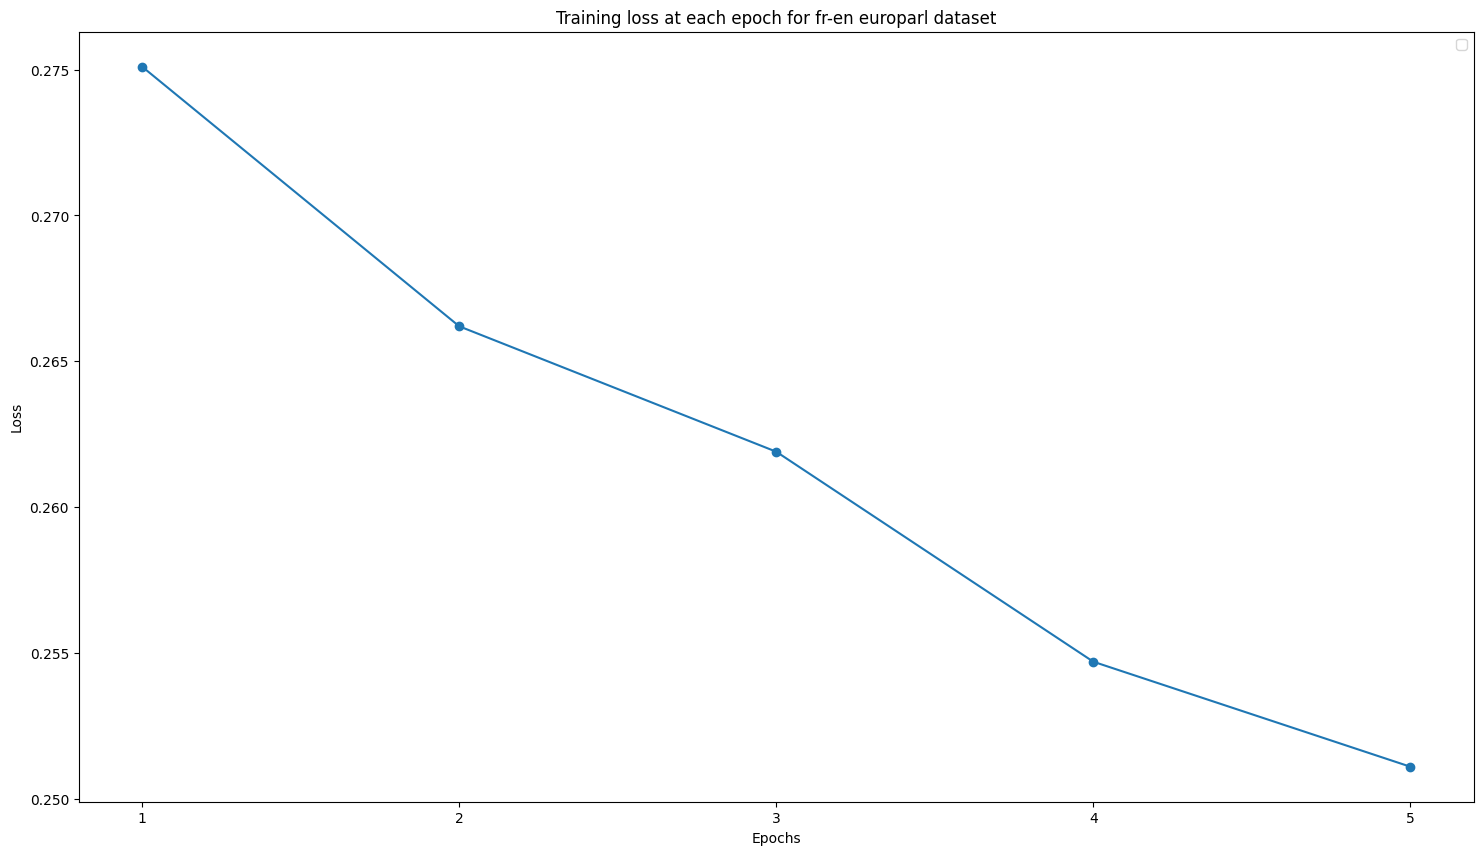

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize = (18,10))
epochs = [1,2,3,4,5]
loss = [0.2751, 0.2662, 0.2619, 0.2547,0.2511]
plt.plot(epochs, loss, marker='o')
plt.title('Training loss at each epoch for fr-en europarl dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.xticks(epochs)
plt.legend()
$plt.show()$

## Configured till above